# Import

In [1]:
import csv
import os
import pickle
import sys

import numpy as np
import pandas as pd
from sklearn.mixture import BayesianGaussianMixture
from tqdm import tqdm

## Add configuration file

In [2]:
sys.path.append("/home/jovyan/core/config/")
sys.path.append("/home/jovyan/core/util/")

In [3]:
from ALL import config 
from util import *

## Set condition

In [4]:
tqdm.pandas()
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 50)

In [5]:
data_type="AgNewsTitle"
vectorize_type = "sentenceBERT"

# Read data

In [6]:
df = pd.read_csv(
    f"../../Preprocessing/data/{data_type}/master.csv", index_col=0
)

In [7]:
with open(f"../../Preprocessing/data/{data_type}/class.csv", mode="r") as f:
    reader = csv.reader(f)
    class_labels = [label for label in reader]

In [19]:
max_vector_model_num = config["vectorize"][vectorize_type]["max_model_num"]
# vector_dims = config["vectorize"][vectorize_type]["dims"]
vector_dims = [2]
normalization = config["vectorize"][vectorize_type]["normalization"]
# model_nums = config["clustering"]["gmm"]["max_model_num"]
model_nums = 1
# covariance_types = config["clustering"]["gmm"]["covariance_types"]
covariance_types = ["spherical"]
weight_concentration_priors = [10e-12, 10e-20, 10e-40, 10e-80]

In [20]:
n_components = config["data"][data_type]["class_num"]

# Clustering

In [21]:
def getGMM(
    vectors, n_components, covariance_type, weight_concentration_prior, seed, path
):
    gmm = BayesianGaussianMixture(
        n_components=n_components,
        covariance_type=covariance_type,
        random_state=seed,
        max_iter=1000,
        init_params="k-means++",
        weight_concentration_prior_type="dirichlet_process",
        n_init=1,
        weight_concentration_prior=weight_concentration_prior,
    )
    gmm.fit(vectors)
    # save model
    os.makedirs(os.path.dirname(path), exist_ok=True)
    pickle.dump(gmm, open(path, "wb"))
    pred = gmm.predict(vectors)
    return pred

In [22]:
vectors_path = f"../data/{data_type}/{vectorize_type}/vector"
models_path = f"../data/{data_type}/{vectorize_type}/BayesianGMM/model"
pred_path = f"../data/{data_type}/{vectorize_type}/BayesianGMM/pred"

In [44]:
preds = {}
for vector_model_num in range(max_vector_model_num):
    for vector_dim in vector_dims:
        for model_num in range(model_nums):
            for covariance_type in covariance_types:
                for weight_concentration_prior in tqdm(weight_concentration_priors):
                    vectors = np.load(
                        f"{vectors_path}/{vector_dim}/{normalization}/{vector_model_num}.npy"
                    )
                    vectors = vectors[2000:3000]
                    pred = getGMM(
                        vectors,
                        seed=model_num,
                        n_components=100,
                        covariance_type=covariance_type,
                        weight_concentration_prior=weight_concentration_prior,
                        path=f"{models_path}/{vector_dim}/{normalization}/{covariance_type}/{model_num}.sav",
                    )
                    preds[weight_concentration_prior] = pred
                    # save prediction
                    np.save(
                        make_filepath(
                            f"{pred_path}/{vector_dim}/{normalization}/{covariance_type}/{model_num}.npy"
                        ),
                        pred,
                    )

100%|██████████| 4/4 [00:03<00:00,  1.31it/s]


In [45]:
for prior, pred in preds.items():
    print(prior, len(set(pred)))

1e-11 10
1e-19 10
1e-39 10
1e-79 10


In [30]:
send_line_notify(f"end {data_type} {vectorize_type}")

In [46]:
import matplotlib.pyplot as plt

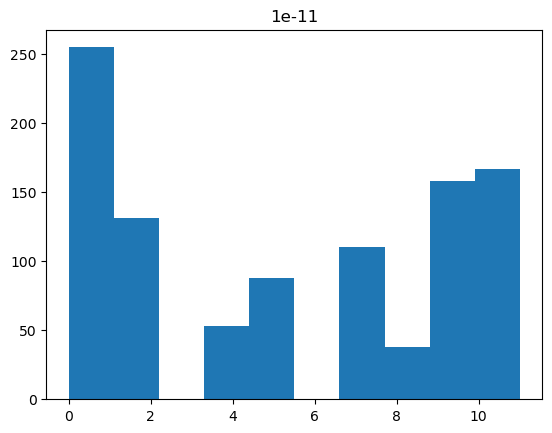

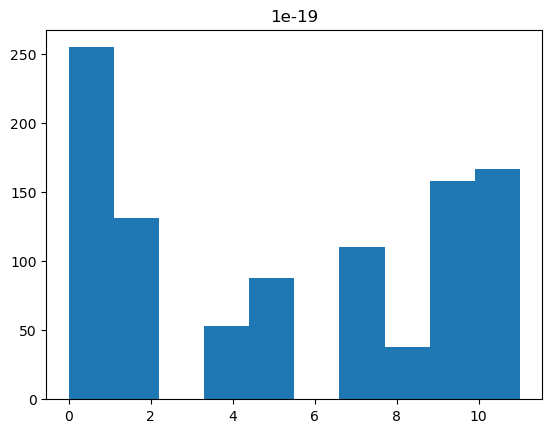

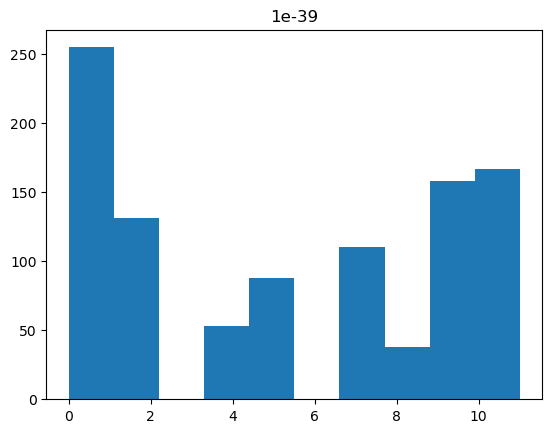

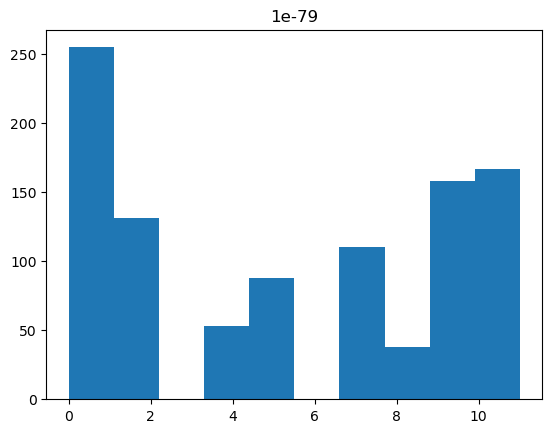

In [47]:
for prior, pred in preds.items():
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.hist(pred, bins= len(set(pred)))
    ax.set_title(prior)

In [27]:
send_line_notify(f"Bayesian {data_type} {vectorize_type}")